# TP Large Scale Kernel Methods

In [1]:
# general imports
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# data loading and partitioning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file

# question 1
from sklearn.svm import SVC, LinearSVC
from time import time
from sklearn.metrics import accuracy_score

# question 2
from scipy.sparse.linalg import svds
from scipy.linalg import svd
from numpy import diag
from numpy import dot

# question 3
from numpy import sqrt
from numpy import sum

# question 4
from numpy.random import normal
from numpy.random import uniform
from numpy import pi
from numpy import cos
from numpy.matlib import repmat

# question 6
from sklearn.metrics.pairwise import rbf_kernel

## Chargement et partitionnement des données

In [2]:
###############################################################################
# Requires file ijcnn1.dat.gz to be present in the directory

# default path: uncomment to restore
#dataset_path = 'ijcnn1.dat.gz'

# path on my own laptop: omment to ignore
dataset_path = '/home/romain/jupyter/ijcnn1.dat'

ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Nombre d'exemples d'apprentissage:", n1)
print("Nombre d'exemples de test:", n2)
print("Nombre de features:", p)

Nombre d'exemples d'apprentissage: 20000
Nombre d'exemples de test: 40000
Nombre de features: 22


## Question 1

On va fitter nos données d'apprentissage avec un SVM linéaire et un SVM non-linéaire (noyau Gaussien) pour comparer leur score de prédiction ainsi que le temps de calcul nécessaire à l'apprentissage et à la prédiction.

In [3]:
print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()
# fit SVM with Gaussian kernel
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
timing_kernel = time() - t0
print("done in %0.3fs" % (time() - t0))

# obtain predictions
print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t1))

# compute accuracy
accuracy_kernel = accuracy_score(y_test, y_pred)
print("classification accuracy: %0.3f" % accuracy_kernel)

Fitting SVC rbf on 20000 samples...
done in 3.929s
Predicting with SVC rbf on 40000 samples...
done in 4.748s
classification accuracy: 0.980


In [4]:
# the exercise is repeated with a linear SVM
print("Fitting linear SVC on %d samples..." % X_train.shape[0])
t0 = time()

# fit SVM with linear kernel
clf_linear = LinearSVC(dual=False)
clf_linear.fit(X_train, y_train)
timing_linear = time() - t0
print("done in %0.3fs" % (time() - t0))

# obtain predictions
print("Predicting with linear SVC on %d samples..." % X_test.shape[0])
t1 = time()
y_pred_linear = clf_linear.predict(X_test)
print("done in %0.3fs" % (time() - t1))

# compute accuracy
accuracy_linear = accuracy_score(y_test, y_pred_linear)
print("classification accuracy: %0.3f" % accuracy_linear) 

Fitting linear SVC on 20000 samples...
done in 0.096s
Predicting with linear SVC on 40000 samples...
done in 0.002s
classification accuracy: 0.917


In [5]:
print("The estimation time with the linear SVC is " + str(round(timing_kernel/timing_linear)) + \
      " times shorter than that of the SVC with Gaussian kernel.")

The estimation time with the linear SVC is 41 times shorter than that of the SVC with Gaussian kernel.


On tire deux conclusions de l'exercice. 

Premièrement, le SVM linéaire est considérablement plus rapide que le SVM à noyau gaussien en termes d'estimation, puisque la phase de fit est environ 35 fois plus courte. On pourrait donc être tenté d'adopter un SVM linéaire lorsque l'on a affaire à de très grands volumes de données, afin d'assurer un passage à l'échelle dans des temps d'estimation raisonnables.

Toutefois, la seconde conclusion est que le gain de temps lié au SVM linéaire est réalisé au détriment de la performance. Alors que la précision du SVM à noyau Gaussien est très élevée (0.98), celle du SVM linéaire est bien plus basse (0.917).

On peut donc en conclure qu'il est nécessaire d'utiliser un SVC à noyaux pour obtenir de bonnes performances. Même si le SVM linéaire s'avère plus rapide, la dégradation de performance est telle qu'on ne peut pas envisager de l'utiliser, même sur de grands volumes de données. Il conviendra donc de trouver une meilleure solution pour passer à l'échelle, qui permette notamment l'utilisation de noyaux.

## Question 2

On code une fonction qui calcule la meilleure approximation de rang $k$.

In [6]:
def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        U_k, Lambda_k, U_kt = svds(gram_mat, k=k)
        gram_mat_k = dot(U_k, dot(diag(Lambda_k), U_kt))
    else:
        U, Lambda, Ut = svd(gram_mat)
        U_k, Lambda_k, U_kt = U[:,:k], Lambda[:k], Ut[:k,:]
        gram_mat_k = dot(dot(U_k, diag(Lambda_k)), U_kt)
    return gram_mat_k

## Question 3

On applique cette fonction sur la matrice décrite dans le sujet de TP.

In [7]:
p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error = np.zeros(n_ranks)

# adding a Frobenius norm function (definition from course on similarity and distance metric learning, slide 22)
def Frobenius_norm(A):
    return sqrt(sum(A**2))

for k, rank in enumerate(ranks):
    # print(k, rank)
    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0

    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0

    # compute relative error with Frobenius norm
    rel_error[k] = Frobenius_norm(gram_signal-gram_mat_k) / Frobenius_norm(gram_signal)

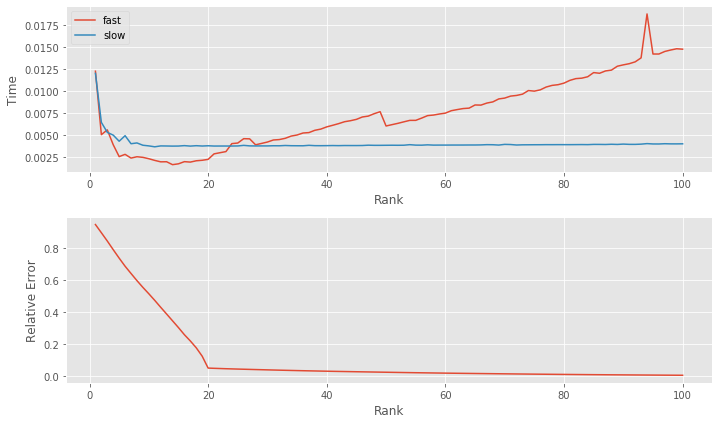

In [8]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax2.plot(ranks, rel_error, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')
plt.tight_layout()
plt.show()

On tire deux conclusions:

- tout d'abord, la méthode "rapide" ne semble en réalité rapide que pour les petites valeurs de $k$. Cela est normal: l'algorithme svds est optimisé pour les matrices creuses (sparse). Bien qu'il puisse aussi être utilisé pour des matrices denses, il n'est vraiment efficace que pour les matrices creuses, ou pour les matrices denses pour lequelles on ne calcule que quelques valeurs propres. Dans notre cas, on se rend compte que le coût de l'algorithme augmente linéairement avec le nombre de valeurs propres à calculer, et qu'au-delà de 25 il dépasse celui de l'algorithme SVD. Ce dernier a en revanche logiquement un coût stable puisqu'il calcule de base toutes les valeurs propres.

- On se rend compte que l'erreur relative suit un comportement non-linéaire. Elle décroît très rapidement entre 0 et 20 valeur propres. Ensuite, elle décroît beaucoup plus lentement entre 20 et 100. Le bénéfice absolu sur ce second segment est très faible, puisque l'erreur progresse à peine de 5%. On peut donc en conclure qu'il n'est pas utile de dépasser $k=20$, qui représente le meilleur compromis entre précision de l'approximation et coût en calcul.

## Question 4

On va implémenter l'algorithme de Random Kernel Features pour le noyau Gaussien.

In [9]:
def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    W = rng.normal(0, sqrt(2*gamma), (n_features, c))
    b = rng.uniform(0, 2*pi, (1,c))
    X_new_train = sqrt(2/c) * cos(dot(X_train, W) + b)
    X_new_test = sqrt(2/c) * cos(dot(X_test, W) + b)
        
    return X_new_train, X_new_test

## Question 5

On va maintenant appliquer cette méthode avec $c=300$.

In [10]:
n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

t0 = time()
Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)
generation_rkf = time() - t0

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
timing_rkf = time() - t0
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)

Fitting SVC linear on 20000 samples...
done in 1.359s
Predicting with SVC linear on 40000 samples...
done in 0.014s
classification accuracy: 0.963


In [11]:
print("Il a fallu " + str(round(generation_rkf,2)) + " secondes pour générer les features.")
print()
print("Le temps d'estimation avec la méthode random kernel feature est " + str(round(timing_kernel/timing_rkf,2))\
      + " fois plus court qu'en utilisant les features normales avec un noyau gaussien.")

Il a fallu 0.18 secondes pour générer les features.

Le temps d'estimation avec la méthode random kernel feature est 2.89 fois plus court qu'en utilisant les features normales avec un noyau gaussien.


On tire les conclusions suivantes:
    
- le temps d'estimation du modèle SVM a été considérablement raccourci en utilisant la méthode random kernel features, par rapport à la méthode normale avec un noyau gaussien. Il est en effet divisé par plus de trois. Il reste toutefois plus élevé qu'en utilisant le modèle linéaire initial, ce qui est normal puisque le coût de la méthode est qu'il faut augmenter le nombre de features (ici poussé à 300, comparé à 22 initialement).

- la performance du modèle random kernel features est très bonne, et proche du modèle original à noyau gaussien (précision de 0.96 environ avec random kernel feature, comparé à 0.98 pour le modèle original). Il demeure toutefois une légère perte de performance, qui s'explique par le fait que la méthode random kernel features ne peut fournir qu'une approximation de la valeur du noyau, avec en conséquence une légère perte de précision.

## Question 6

On implémente la méthode de Nystrom.

In [12]:
def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    # computation of W_k and M_k from singular value decomposition of W
    V, Sigma, Vt = svd(W)
    V_k, Sigma_k, V_kt = V[:,:k], Sigma[:k], Vt[:k,:]
    W_k = dot(dot(V_k, diag(Sigma_k)), V_kt)
    M_k = dot(V_k, diag(1/sqrt(Sigma_k)))
    
    # calculation of C matrices
    C_train = rbf_kernel(X_train, X_train_idx, gamma=gamma)
    C_test = rbf_kernel(X_test, X_train_idx, gamma=gamma)
    
    # computation of the new features
    X_new_train = dot(C_train, M_k)
    X_new_test = dot(C_test, M_k)

    return X_new_train, X_new_test

## Question 7

On va maintenant appliquer cette méthode également avec $c=500$ et $k=300$

In [13]:
t0 = time()
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)
generation_nystrom = time() - t0

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
timing_nystrom = time() - t0
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)


Fitting SVC linear on 20000 samples...
done in 1.063s
Predicting with SVC linear on 40000 samples...
done in 0.014s
classification accuracy: 0.976


In [14]:
print("Il a fallu " + str(round(generation_nystrom,2)) + " secondes pour générer les features, ce qui est " +\
str(round(generation_nystrom/generation_rkf, 2)) + " fois plus long qu'avec la méthode rkf.")
print()
print("Le temps d'estimation avec l'approximation de Nystrom est " + str(round(timing_kernel/timing_nystrom,2))\
      + " fois plus court qu'en utilisant les features normales avec un noyau gaussien.")

Il a fallu 0.53 secondes pour générer les features, ce qui est 2.96 fois plus long qu'avec la méthode rkf.

Le temps d'estimation avec l'approximation de Nystrom est 3.7 fois plus court qu'en utilisant les features normales avec un noyau gaussien.


On tire les conclusions suivantes:
    
- le temps d'estimation du modèle SVM est là encore considérablement plus court qu'avec la méthode initiale utilisant un noyau gaussien. Il est en effet divisé par plus de trois, ce qui est très similaire au gain obtenu avec la méthode rkf. Ce n'est guère étonnant puisque les modèles travaillent à peu près avec la même dimension de features (c=500 pour Nystrom, c=300 pour rkf).

- le cours (slide 36) précise que "rkf are generally cheaper to generate". Cela est confirmé ici: générer les features avec Nystrom tend à être plus long qu'avec rkf. Dans une optique de passage à l'échelle, il conviendra de tenir compte de ce facteur en plus de la comparaison du temps d'estimation du modèle SVM.

- la performance du modèle avec approximation de Nystrom est excellente, et virtuellement similaire à celle du modèle original à noyau gaussien (précision de 0.976 environ avec random kernel feature, comparé à 0.98 pour le modèle original). Cette performance est meilleure que celle de la méthode rkf, toutefois celle-ci n'est estimée qu'avec 300 features. Un essai rapide en utilisant la valeur c=500 en rkf donne une précision de 0.974, proche mais légèrement inférieure à celle de l'approximation de Nystrom. Cela confirme donc, à la marge, ce qui est dit dans le cours (slide 36): "At equal number of random samples, Nystrom tends to achieve better performance"

## Question 8

On va maintenant réaliser une synthèse des performances des RKF et de Nystrom pour un ensemble de paramètres.

In [15]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)

timing_kernel = np.zeros(n_ranks)
timing_linear = np.zeros(n_ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)

accuracy_kernel = np.zeros(n_ranks)
accuracy_linear = np.zeros(n_ranks)
accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    print(i, c)
    
    # initiate timer for rkf
    t0 = time()
    # generate features for rkf model
    Z_train, Z_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    # train SVM on rkf features
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    # obtain accuracy (and record timer)
    accuracy_rkf[i] = clf.score(Z_test, y_test)
    timing_rkf[i] = time() - t0
    
    # initiate timer again for Nystrom
    t0 = time()
    # generate now features for the Nystrom approximation model
    Z_train, Z_test = nystrom(X_train, X_test, gamma, c=c, k=c-10, seed=44)
    # train SVM on Nystrom features
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    # obtain accuracy (and record timer)
    accuracy_nystrom[i] = clf.score(Z_test, y_test)
    timing_nystrom[i] = time() - t0
    
    # initiate timer again for classic rbf
    t0 = time()
    # train SVM
    clf = SVC(kernel='rbf')
    clf.fit(X_train, y_train)
    # obtain accuracy (and record timer)
    accuracy_kernel[i] = clf.score(X_test, y_test)
    timing_kernel[i] = time() - t0
    
    # initiate timer again for linear model
    t0 = time()
    # train SVM
    clf = LinearSVC(dual=False)
    clf.fit(X_train, y_train)
    # obtain accuracy (and record timer)
    accuracy_linear[i] = clf.score(X_test, y_test)
    timing_linear[i] = time() - t0
    

Training SVMs for various values of c...
0 20
1 70
2 120
3 170
4 220
5 270
6 320
7 370
8 420
9 470
10 520
11 570


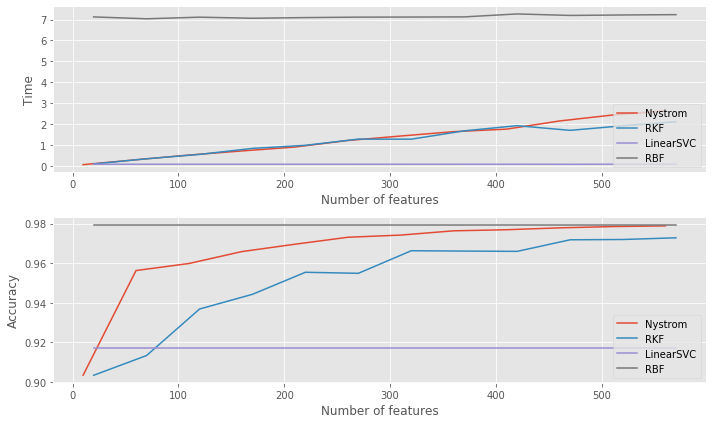

In [16]:
###############################################################################
# Display bis

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

Remarque préliminaire: l'énoncé de l'exercice demande d'estimer le temps de calcul total comme la somme du temps d'entrainement et de prédiction. J'ajoute à ce temps là le temps de création des features pour les modèles rkf et Nystrom car c'est la seule manière de donner du sens à ce chronométrage. En effet, si on ne compte pas la création des features, on estime le même modèle linéaire sur le même nombre de features générés, et sans surprise le temps de calcul total est exactement le même, ce qui n'est pas informatif.

On peut tirer de ces graphiques les conclusions suivantes:

- en termes de temps de calcul, on obtient des résultats cohérents avec ce qu'on pouvait attendre. Le modèle linéaire est le plus rapide à estimer, car il repose sur le plus petit nombre de features (22). Comme il ne dépend pas de k, son temps d'estimation est constant. A l'autre extrême, le modèle à noyau gaussien est le plus lent à calculer, ce qui est normal car il estime l'intégralité de la matrice de Gram, sans simplification. Entre les deux, les modèles rkf et Nystrom offrent un compromis. Ils sont équivalents au modèle linéaire pour c=22, puis voient le temps de calcul augmenter de façon linéaire avec le nombre de features c. On remarque que même pour un grand nombre de features (c=500), ils restent considérablement plus rapide que le modèle à noyau (2,5 secondes au lieu de 7), ce qui confirme leur intérêt pour le passage à l'échelle. On note que le modèle rkf est très légèrement plus rapide que le modèle de Nystrom pour les grandes valeurs de c, ce qui confirme les conclusions précédentes.

- concernant la performance, les résultats sont là encore conformes aux attentes. Le meilleur modèle est celui à noyau, car il estime la totalité de la matrice de Gram sans aucune approximation. Il atteint les 0.98 en précision. Le modèle linéaire est celui qui fournit la pire performance et plafone à 0.92 en précision. Entre les deux, les modèles Nystrom et rkf offrent, là encore, un compromis. Pour les très petites valeurs de c, ils sont plus mauvais que le modèle linéaire, mais le dépassent dès qu'on inclut quelques dizaines de features (20 pour Nystrom, 80 pour rkf). La performance augmente logiquement à mesure qu'on augmente le nombre de features dans l'approximation. On remarque que Nystrom obtient une meilleure performance que rkf, ce qui confirme là aussi les conclusions précédentes. Enfin, on note que Nystrom atteint vers 500 features la précision du modèle à noyau, ce qui montre une convergence asymptotique vers le vrai modèle à noyau.

- le choix final du modèle relève du meilleur compromis. Le modèle linaire est efficace en calcul mais mauvais en prédiction. Le modèle à noyau est le meilleur en prédiction mais trop gourmand en calcul pour un passage à l'échelle. Le meilleur compromis est le modèle de l'approximation de Nystrom, qui atteint virtuellement la même performance que le modèle à noyaux, tout en étant trois fois moins coûteux en calcul. Le modèle rkf semble légèrement inférieur à celui de Nystrom, étant équivalent en temps de calcul, mais moins bon en précision.